<span style = "color:blue; font-size:24px">ARIMADecisionTreeTester</span>
<span style = "color:blue; font-size:24px">Credential Access</span>

ZeekData24 Attack Profiles

Dataset 1: Multiple Attack Types (Credential Access|236706|, Reconnaissance|12762|, Initial Access|2172|, Privilege Escalation|1251|, Persistence|1251|, Defense Evasion|1251|, Exfiltration|50|)

Dataset 2: Multiple Attack Types (Credential Access|45491|, Reconnaissance|3339|, Initial Access|576|, Privilege Escalation|336|, Persistence|336|, Defense Evasion|336|, Exfiltration|30|)

Dataset 3: Multiple Attack Types (Credential Access|150887|, Reconnaissance|10834|, Initial Access|2090|, Privilege Escalation|1193|, Persistence|1193|, Defense Evasion|1193|, Exfiltration|188|)

Dataset 4: Multiple Attack Types (Credential Access|341945|, Reconnaissance|24233|, Initial Access|4602|, Privilege Escalation|2591|, Persistence|2591|, Defense Evasion|2591|, Exfiltration|268|)

Dataset 5: Multiple Attack Types (Credential Access|96159|, Reconnaissance|6927|, Initial Access|1222|, Privilege Escalation|677|, Persistence|677|, Defense Evasion|677|, Exfiltration|23|)

Datest 6: Benign Data

Dataset 7: Benign Data

Zeekdata22 Attack Profiles

Dataset 1: Benign

Dataset 2: Attacks (Reconnaissance|9278720|, Discovery|2086|)

Dataset 3: Attacks (Credential Access|31|, Privilege Escalation|13|, Exfiltration|7|, Lateral Movement|4|, Resource Development|3|, Reconnaissance|2|, Persistence|1|, Initial Access|1|, Defense Evasion|1|)

This revision tests the Decision Tree Model on different combinations of 2022 and 2024 data but focuses on Credential Access.

<span style = "color:blue; font-size:24px">Preprocessing for ARIMA Model</span>

In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

# Paths containing network data
data_paths = ["hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
            ]
# Predefined list of MITRE ATT&CK labels
mitre_labels = [
    "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
    "Credential Access", "Discovery", "Lateral Movement", "Collection",
    "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
]

# Container to hold the processed DataFrames
df_list = []

# Counter variable
j = 0

# Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)
   
    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
   
    #Show all rows of attack labels before any preprocessing
    print(f"Dataset {j+1}: All rows of 'label_tactic' before preprocessing:")
    all_label_tactics = df.select("label_tactic").distinct().collect()
    for row in all_label_tactics:
        print(row['label_tactic'])
              
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0,
        "label_tactic": "none"  # Default to 'none'
    })

    # Print unique count for each tactic type
    print(f"Dataset {j+1}: Unique count for each 'label_tactic' value before conversion")
    unique_tactic_counts = df.groupBy("label_tactic").count().orderBy(F.desc("count"))
    unique_tactic_counts.show(truncate=False)
   
    # Convert 'label_tactic' to binary: 'none' -> 0, anything else -> 1
    df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))

    # Show the first few rows after binary conversion to verify
    print(f"First few rows after binary encoding:")
    df.select("label_tactic", "label_tactic_binary").show(5, truncate=False)

    # Convert 'label_tactic' to list of attack types for encoding
    df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
   
    # Perform MultiLabel encoding (before aggregation)
    df = df.withColumn("label_tactic_binary_encoded", F.expr(
        "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
    ))

    # Show the first few rows of 'label_tactic_binary_encoded' to check encoding
    print(f"First few rows of 'label_tactic_binary_encoded' (encoded attack types):")
    df.select("label_tactic", "label_tactic_split", "label_tactic_binary_encoded").show(5, truncate=False)

    #Time window 
    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
   
    # Aggregate data within time windows
    window_size = "1 seconds"
    stride = "0 minutes"  # Remove overlap
    
    df_agg = df.groupBy(F.window("ts", window_size)) \
        .agg(
            F.sum("duration").alias("sum_duration"),
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count"),
            F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
            F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
            F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_duration",
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count",
        "label_tactic_binary_agg",
        "label_tactic_split_agg",
        "label_tactic_binary_encoded_agg"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
   
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    # Log-transform only (no normalization)
    df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])

    # Print the number of rows
    print(f"DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    # Print unique 'label_tactic_split_agg' values
    print(f"Dataset {j+1}: Unique 'label_tactic_split_agg' values")
    unique_label_tactic_agg = df_agg_sorted.select("label_tactic_split_agg").distinct().collect()
    for row in unique_label_tactic_agg:
        print(row['label_tactic_split_agg'])

    # Add to DataFrame List
    df_list.append(df_pandas_sorted)

    #Indicate data finished loading
    print(f"Dataset {j+1} loaded successfully")

    j += 1

# Define training and testing datasets for ARIMA model
df_train_sample = df_list[7]
df_test_sample = pd.concat(df_list[6:8])
df_test_original = df_test_sample.copy()    

25/03/03 08:10:23 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.112 instead (on interface ens33)
25/03/03 08:10:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/03 08:10:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/03 08:10:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/03 08:10:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Dataset 1: All rows of 'label_tactic' before preprocessing:


none
Dataset 1: Unique count for each 'label_tactic' value before conversion


+------------+------+
|label_tactic|count |
+------------+------+
|none        |428724|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet has total rows: 27473
Dataset 1: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 1 loaded successfully
Dataset 2: All rows of 'label_tactic' before preprocessing:
none
Dataset 2: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757069|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet has total rows: 112819
Dataset 2: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 2 loaded successfully
Dataset 3: All rows of 'label_tactic' before preprocessing:
none
Dataset 3: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757998|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet has total rows: 113015
Dataset 3: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 3 loaded successfully
Dataset 4: All rows of 'label_tactic' before preprocessing:


none
Dataset 4: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2403853|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet has total rows: 172831
Dataset 4: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 4 loaded successfully
Dataset 5: All rows of 'label_tactic' before preprocessing:
none
Dataset 5: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2579855|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet has total rows: 224162
Dataset 5: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 5 loaded successfully
Dataset 6: All rows of 'label_tactic' before preprocessing:
none
Dataset 6: Unique count for each 'label_tactic' value before conversion
+------------+------+
|label_tactic|count |
+------------+------+
|none        |354100|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet has total rows: 31935
Dataset 6: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 6 loaded successfully
Dataset 7: All rows of 'label_tactic' before preprocessing:


Discovery
Reconnaissance
Dataset 7: Unique count for each 'label_tactic' value before conversion


+--------------+-------+
|label_tactic  |count  |
+--------------+-------+
|Reconnaissance|9278720|
|Discovery     |2086   |
+--------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):


+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
+------------+------------------+---------------------------------------+
only showing top 5 rows



DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet has total rows: 1192
Dataset 7: Unique 'label_tactic_split_agg' values


[['Discovery']]
[['Reconnaissance']]
Dataset 7 loaded successfully
Dataset 8: All rows of 'label_tactic' before preprocessing:
Lateral Movement
Resource Development
Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 8: Unique count for each 'label_tactic' value before conversion
+--------------------+-----+
|label_tactic        |count|
+--------------------+-----+
|Credential Access   |31   |
|Privilege Escalation|13   |
|Exfiltration        |7    |
|Lateral Movement    |4    |
|Resource Development|3    |
|Reconnaissance      |2    |
|Persistence         |1    |
|Initial Access      |1    |
|Defense Evasion     |1    |
+--------------------+-----+

First few rows after binary encoding:
+--------------------+-------------------+
|label_tactic        |label_tactic_binary|
+--------------------+-------------------+
|Defense Evasion     |1                  |
|Initial Access      |1                  |
|Persistence         |

<span style = "color:blue; font-size:24px">Preprocessing for Decision Tree</span>

In [2]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import openpyxl
from openpyxl import Workbook
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Pre-Preprocess Mission Log") \
    .master("spark://192.168.1.2:7077") \
    .config("spark.driver.cores", "2") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.cores", "3") \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "5") \
    .config("spark.dynamicAllocation.maxExecutors", "8") \
    .config("spark.executor.instances", "5") \
    .getOrCreate()

# Paths containing 2024 network data
data_paths_2024 = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet"
]

# Paths containing 2022 network data
data_paths_2022 = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
]

# Function to load and preprocess data
def load_and_preprocess_data(data_paths):
    df_list = []
    for path in data_paths:
        df = spark.read.parquet(path)
        df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
        df = df.fillna({
            "duration": 0,
            "orig_bytes": 0,
            "resp_bytes": 0,
            "orig_ip_bytes": 0,
            "resp_ip_bytes": 0
        })
        df_list.append(df)
    combined_df = df_list[0]
    for df in df_list[1:]:
        combined_df = combined_df.union(df)
    return combined_df

# Load and preprocess 2024 data
combined_df_2024 = load_and_preprocess_data(data_paths_2024)

# Load and preprocess 2022 data
combined_df_2022 = load_and_preprocess_data(data_paths_2022)

# Print the column names of combined_df_2022
print("Columns in combined_df_2022:")
print(combined_df_2022.columns)

# Print the column names of combined_df_2024
print("Columns in combined_df_2024:")
print(combined_df_2024.columns)

Columns in combined_df_2022:
['ts', 'duration', 'orig_bytes', 'resp_bytes', 'orig_ip_bytes', 'resp_ip_bytes', 'label_tactic']
Columns in combined_df_2024:
['ts', 'duration', 'orig_bytes', 'resp_bytes', 'orig_ip_bytes', 'resp_ip_bytes', 'label_tactic']


ADF Statistic: -4.230108
p-value: 0.000586
Critical Values: 
	1%: -3.610
	5%: -2.939
	10%: -2.608
The time series for the sampled dataset is stationary (reject H0)


25/03/03 08:13:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


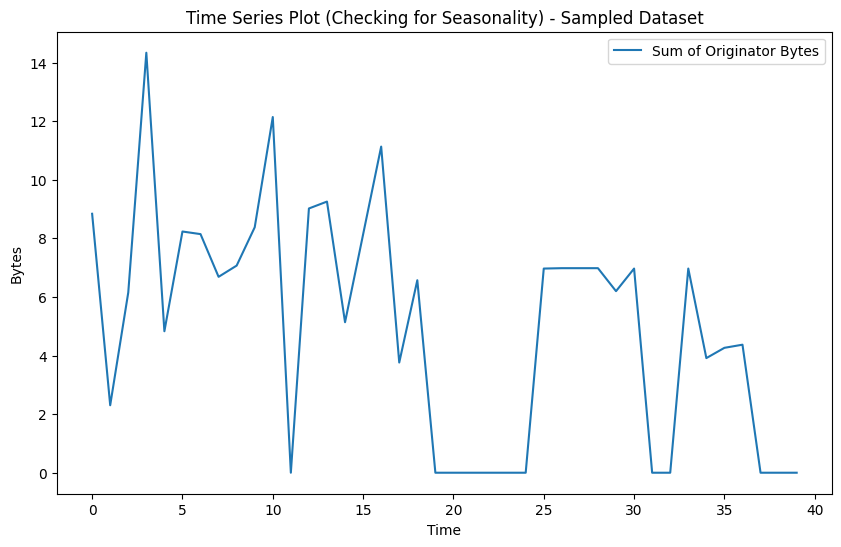

The sampled time series shows evidence of seasonality with a period of 2.


<Figure size 1000x600 with 0 Axes>

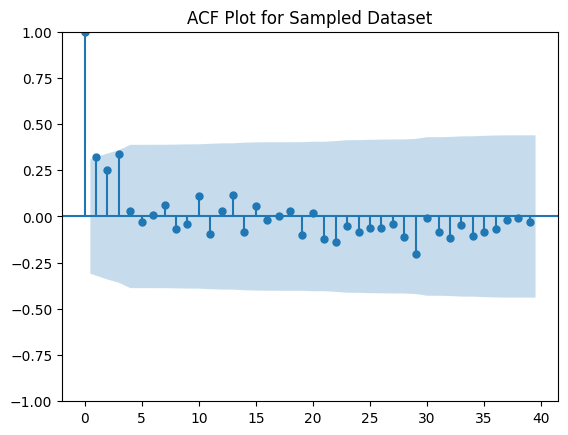

Seasonal periods detected: [2]
Fitting auto_arima with seasonality...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[2] intercept   : AIC=233.987, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=231.861, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=223.754, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=229.960, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=225.152, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[2] intercept   : AIC=223.313, Time=0.03 sec
 ARIMA(1,1,0)(2,0,1)[2] intercept   : AIC=225.674, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[2] intercept   : AIC=219.876, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[2] intercept   : AIC=218.749, Time=0.04 sec
 ARIMA(1,1,0)(0,0,2)[2] intercept   : AIC=219.742, Time=0.04 sec
 ARIMA(1,1,0)(1,0,2)[2] intercept   : AIC=221.418, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[2] intercept   : AIC=232.743, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=inf,

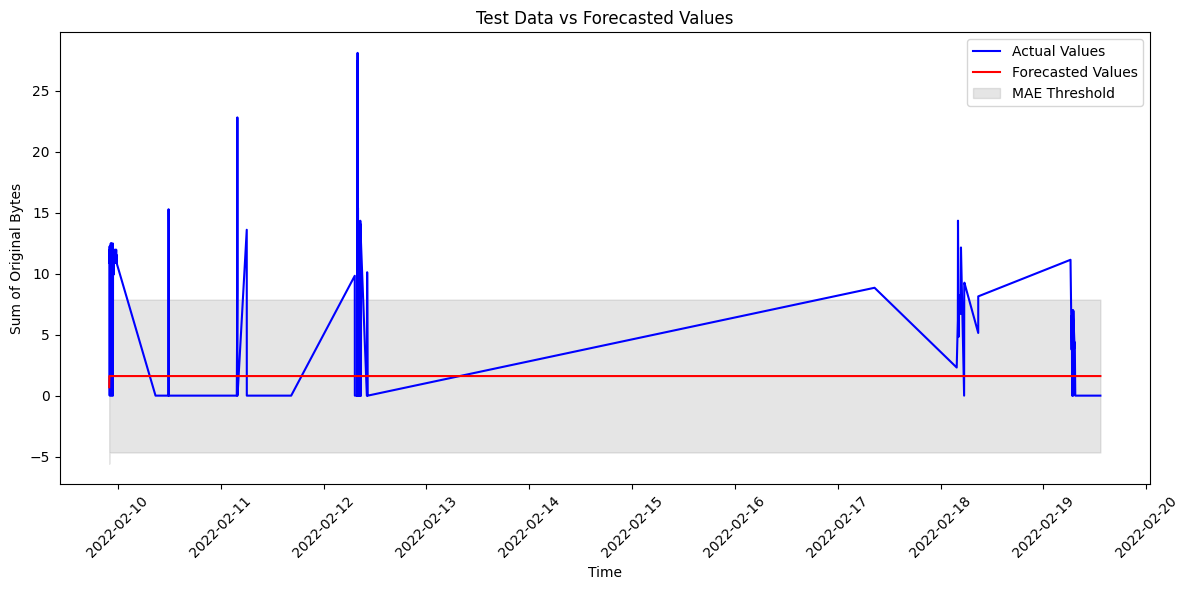

Calling Forecasted Data Processing Function
Columns in forecast_df:
Index(['Time', 'Actual', 'Forecast'], dtype='object')
Columns in df_test_original:
Index(['window_start', 'window_end', 'sum_duration', 'sum_orig_bytes',
       'sum_resp_bytes', 'sum_orig_ip_bytes', 'sum_resp_ip_bytes',
       'connection_count', 'label_tactic_binary_agg', 'label_tactic_split_agg',
       'label_tactic_binary_encoded_agg', 'sum_orig_bytes_log'],
      dtype='object')
40   2022-02-09 21:58:29
41   2022-02-09 21:58:39
42   2022-02-09 21:58:50
43   2022-02-09 21:59:00
44   2022-02-09 21:59:10
Name: Time, dtype: datetime64[ns]
0   2022-02-09 21:58:29
1   2022-02-09 21:58:39
2   2022-02-09 21:58:50
3   2022-02-09 21:59:00
4   2022-02-09 21:59:10
Name: window_start, dtype: datetime64[ns]
                   ts     duration  Forecast     Actual  orig_bytes  \
0 2022-02-09 21:58:29  1281.834961  0.684717  10.882734       53248   
1 2022-02-09 21:58:39  1281.905457  1.136089  10.882734       53248   
2 2022-02-

In [3]:
# Import the functions from the Python script
from arima_functions import train_arima_model, process_forecast
# Import the functions from decision_tree_functions.py
from decision_tree_functions import train_and_evaluate, split_data, train_test_2022_2022, train_test_2024_2024, train_2022_test_2024, train_2024_test_2022

from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("ARIMADecisionTreeTester").getOrCreate()

# Assuming df_train_sample and df_test_sample are already defined
# Call ARIMA Model Training Function
forecast_df = train_arima_model(df_train_sample, df_test_sample)

# Call Forecasted Data Processing Function
print("Calling Forecasted Data Processing Function")
filtered_result_df = process_forecast(df_test_original, forecast_df)

# Print the datatypes of the inputs
print("\nType of combined_df_2024:", type(combined_df_2024))
print("Type of filtered_result_df before conversion:", type(filtered_result_df))

# Convert the DataFrames to Spark DataFrames
filtered_result_df = spark.createDataFrame(filtered_result_df)
print("\nType of filtered_result_df after conversion:", type(filtered_result_df))

Columns and types in train_df:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = true)


Entire test_df:


+-------------------+---------------------+-----------------+------------------+----------+----------+-------------+-------------+-----------------+
|ts                 |duration             |Forecast         |Actual            |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+-------------------+---------------------+-----------------+------------------+----------+----------+-------------+-------------+-----------------+
|2022-02-19 06:34:24|10.018898010253906   |1.604484220378022|3.761200115693563 |42        |168       |2072         |1952         |Credential Access|
|2022-02-19 06:37:11|292.1239471435547    |1.604484220378022|6.569481420414294 |712       |3264      |9456         |18224        |Credential Access|
|2022-02-19 06:40:54|3.039513111114502    |1.604484220378022|0.0               |0         |0         |720          |0            |Credential Access|
|2022-02-19 06:41:03|3.0393080711364746   |1.604484220378022|0.0               |0         |0         |720 


Model for label_tactic: Credential Access
Accuracy: 0.5454545454545454
Precision: 1.0
Recall: 0.5454545454545454
F1 Score: 0.7058823529411764

Predictions for each row in the test dataframe:
+--------------------------------------------------+-----+----------+
|features                                          |label|prediction|
+--------------------------------------------------+-----+----------+
|[10.018898010253906,42.0,168.0,2072.0,1952.0]     |1    |0.0       |
|[292.1239471435547,712.0,3264.0,9456.0,18224.0]   |1    |1.0       |
|(5,[0,3],[3.039513111114502,720.0])               |1    |0.0       |
|(5,[0,3],[3.0393080711364746,720.0])              |1    |0.0       |
|(5,[0,3],[3.8886070251464844E-4,240.0])           |1    |0.0       |
|(5,[0,3],[4.000663757324219E-4,240.0])            |1    |0.0       |
|[87.24535512924194,0.0,140.0,1696.0,2256.0]       |1    |1.0       |
|[223.40260004997253,0.0,47.0,864.0,1052.0]        |1    |1.0       |
|[0.0543210506439209,1061.0,940.0,6772

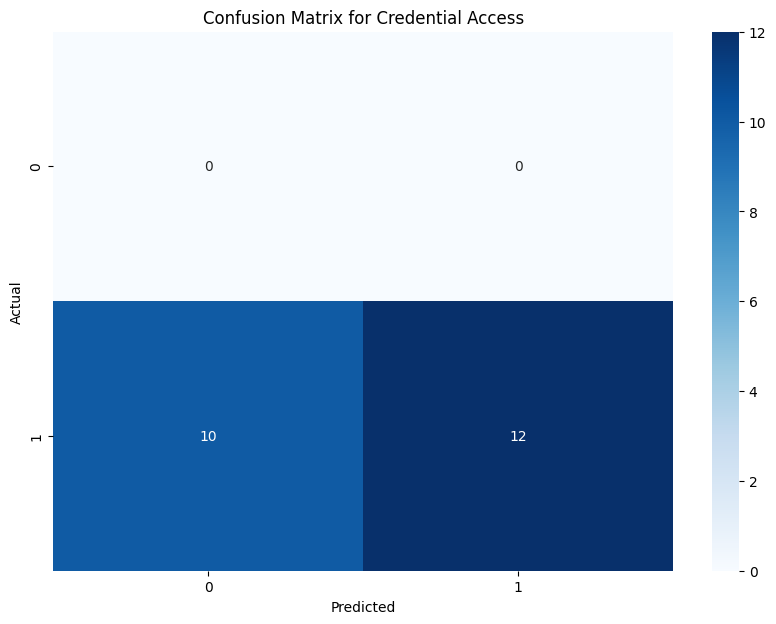

Confusion Matrix plotted.


In [4]:
#Define Test Variables for Decision Tree
#train_df, test_df, tactic, train_year, test_year, split_ratio

train_df = combined_df_2024

# Reduce train_df size to include only the first 70% of data
train_df = train_df.limit(int(0.7 * train_df.count()))

test_df = filtered_result_df

tactic = "Credential Access"
#tactic = "Reconnaissance"

train_year = "2024"

test_year = "2022"

split_ratio = "1"

# Filter train_df to only include rows where label_tactic is either 'none' or the specified tactic
train_df = train_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Filter test_df to only include rows where label_tactic is either 'none' or the specified tactic
test_df = test_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Print the columns and their types for train_df
print("Columns and types in train_df:")
train_df.printSchema()

# Print the test_df
print("\nEntire test_df:")
test_df.show(truncate=False)

#Show the distinct label counts
print("Distinct label counts in train_df:")
train_df.groupBy("label_tactic").count().show()
print("Distinct label counts in test_df:")
test_df.groupBy("label_tactic").count().show()

# Call the train_and_evaluate function
train_and_evaluate(train_df, test_df, tactic, train_year, test_year, split_ratio)


Train 2022 data, Test 2022 data (1)
Arguments: combined_df_2022, tactic=Credential Access, split_ratio=1



Model for label_tactic: Credential Access
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Predictions for each row in the test dataframe:
+--------------------------------------------------+-----+----------+
|features                                          |label|prediction|
+--------------------------------------------------+-----+----------+
|[73.03092908859253,149.0,445.0,1876.0,2804.0]     |1    |1.0       |
|[0.04379987716674805,1075.0,940.0,6828.0,5456.0]  |1    |1.0       |
|[0.0423121452331543,1075.0,940.0,6620.0,5456.0]   |1    |1.0       |
|[0.005376100540161133,243.0,1501.0,2460.0,7076.0] |1    |1.0       |
|[0.0033419132232666016,247.0,1505.0,2476.0,7092.0]|1    |1.0       |
|(5,[0,3],[3.033123016357422,720.0])               |1    |1.0       |
|[0.041068077087402344,1061.0,940.0,6564.0,5456.0] |1    |1.0       |
|[67.35963010787964,35.0,201.0,2668.0,2708.0]      |1    |1.0       |
|[130.1194508075714,39.0,199.0,2892.0,2492.0]      |1    |1.0       |
|[20.21669888

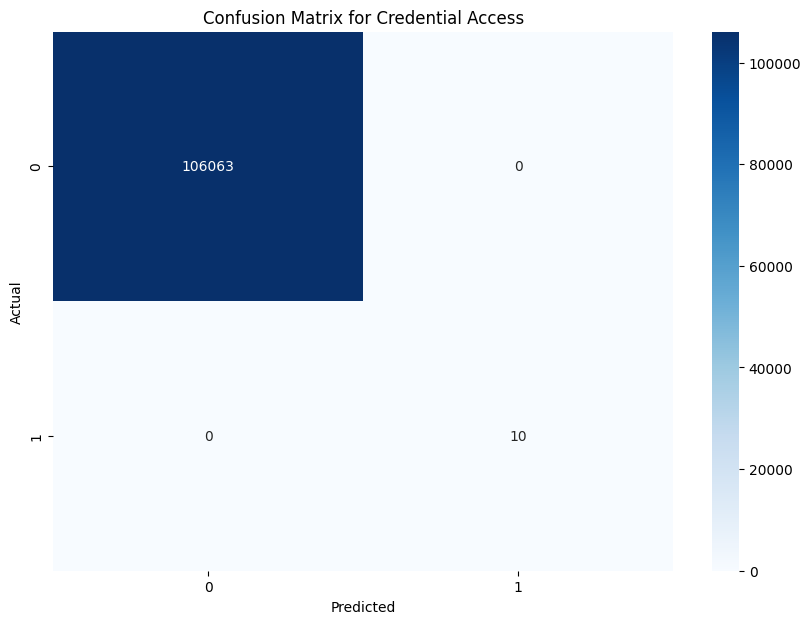

Confusion Matrix plotted.

Train 2024 data, Test 2024 data (1)



Model for label_tactic: Credential Access
Accuracy: 0.9999052524748235
Precision: 0.9999052696080724
Recall: 0.9999052524748235
F1 Score: 0.9999052520445535

Predictions for each row in the test dataframe:
+---------------------------------------------------+-----+----------+
|features                                           |label|prediction|
+---------------------------------------------------+-----+----------+
|[0.006588935852050781,0.0,0.0,864.0,656.0]         |1    |1.0       |
|[3.1452620029449463,150.0,131.0,1880.0,1388.0]     |1    |1.0       |
|[3.099102020263672,834.0,16532.0,5864.0,69696.0]   |1    |1.0       |
|[0.03747200965881348,686.0,11329.0,4856.0,47844.0] |1    |1.0       |
|[2.891839027404785,1004.0,16583.0,6960.0,69900.0]  |1    |1.0       |
|[2.7896511554718018,1005.0,16583.0,6340.0,69900.0] |1    |1.0       |
|[0.028406858444213867,686.0,11329.0,4856.0,47844.0]|1    |1.0       |
|[2.6858198642730713,1004.0,16583.0,6336.0,69900.0] |1    |1.0       |
|[2.32723999

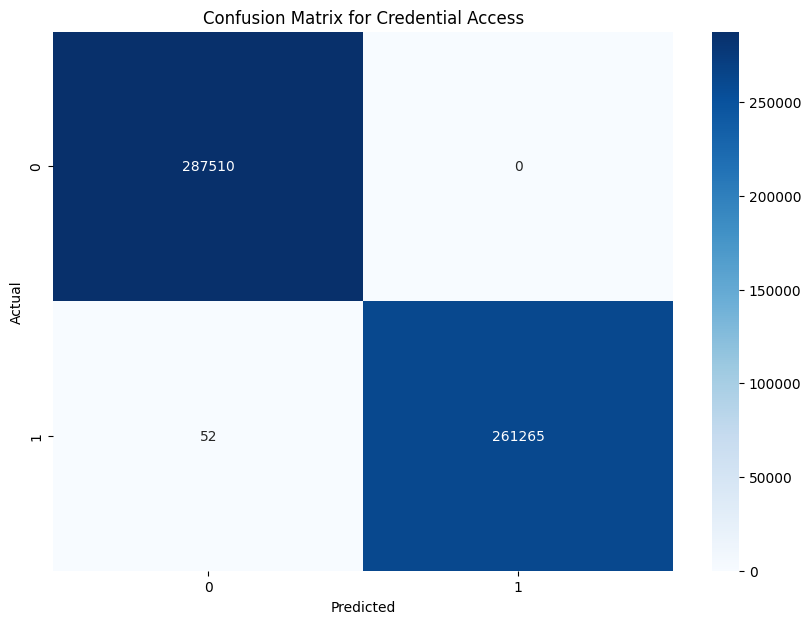

Confusion Matrix plotted.

Train 2022 data, Test 2024 data (1)



Model for label_tactic: Credential Access
Accuracy: 0.999697680577266
Precision: 0.9996978703482454
Recall: 0.9996976805772659
F1 Score: 0.9996976848396788

Predictions for each row in the test dataframe:


+---------------------------------------------------+-----+----------+
|features                                           |label|prediction|
+---------------------------------------------------+-----+----------+
|[0.006588935852050781,0.0,0.0,864.0,656.0]         |1    |1.0       |
|[3.1452620029449463,150.0,131.0,1880.0,1388.0]     |1    |1.0       |
|[0.042643070220947266,686.0,11329.0,4856.0,47844.0]|1    |1.0       |
|[3.099102020263672,834.0,16532.0,5864.0,69696.0]   |1    |1.0       |
|[0.03747200965881348,686.0,11329.0,4856.0,47844.0] |1    |1.0       |
|[2.891839027404785,1004.0,16583.0,6960.0,69900.0]  |1    |1.0       |
|[2.7896511554718018,1005.0,16583.0,6340.0,69900.0] |1    |1.0       |
|[0.028406858444213867,686.0,11329.0,4856.0,47844.0]|1    |1.0       |
|[2.6858198642730713,1004.0,16583.0,6336.0,69900.0] |1    |1.0       |
|[0.028983116149902344,686.0,11329.0,5064.0,47844.0]|1    |1.0       |
|[2.5717899799346924,1008.0,16583.0,6560.0,69900.0] |1    |1.0       |
|[2.46

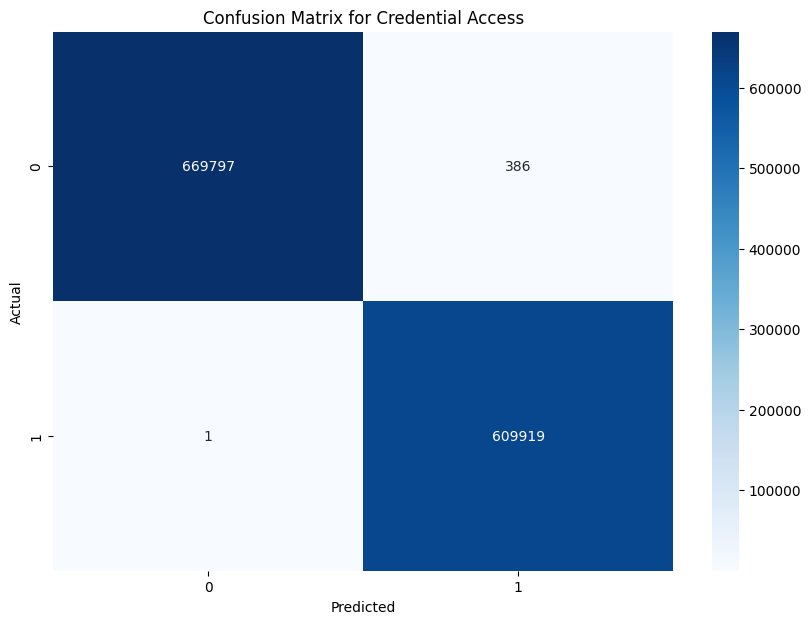

Confusion Matrix plotted.

Train 2024 data, Test 2022 data (1)



Model for label_tactic: Credential Access
Accuracy: 0.9999434752239794
Precision: 0.999943478419146
Recall: 0.9999434752239794
F1 Score: 0.9999311112280391

Predictions for each row in the test dataframe:
+--------------------------------------------------+-----+----------+
|features                                          |label|prediction|
+--------------------------------------------------+-----+----------+
|[10.018898010253906,42.0,168.0,2072.0,1952.0]     |1    |0.0       |
|[73.03092908859253,149.0,445.0,1876.0,2804.0]     |1    |0.0       |
|[73.0279290676117,153.0,375.0,1892.0,2524.0]      |1    |0.0       |
|(5,[0,3],[3.8886070251464844E-4,240.0])           |1    |0.0       |
|(5,[0,3],[4.000663757324219E-4,240.0])            |1    |0.0       |
|[87.24535512924194,0.0,140.0,1696.0,2256.0]       |1    |1.0       |
|[0.04379987716674805,1075.0,940.0,6828.0,5456.0]  |1    |1.0       |
|[0.044133901596069336,1075.0,940.0,6828.0,5456.0] |1    |1.0       |
|[0.0423121452331543,107

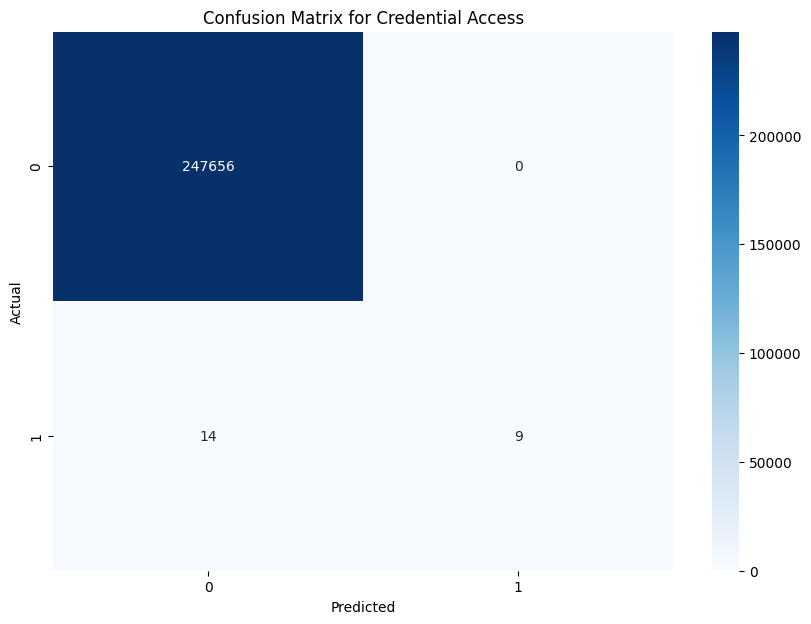

Confusion Matrix plotted.


In [5]:
# Define the parameters
tactic = "Credential Access"
train_ratio = 0.7
test_ratio = 0.3
split_ratio = "1"

# Call the function to train and test the model on the same year, 2022
train_test_2022_2022(combined_df_2022, tactic, train_ratio, split_ratio)

# Call the function to train and test the model on the same year, 2024
train_test_2024_2024(combined_df_2024, tactic, train_ratio, split_ratio)

# Call the function to train the model on 2022 data and test on 2024 data
train_2022_test_2024(combined_df_2022, combined_df_2024, tactic, train_ratio, test_ratio, split_ratio)

# Call the function to train the model on 2024 data and test on 2022 data
train_2024_test_2022(combined_df_2024, combined_df_2022, tactic, train_ratio, test_ratio, split_ratio)